In [1]:
from glob import glob
import re
import pandas as pd

test_train_splits = [{"train": 0, "test": 0} for _ in range(5)]

for file in glob("../data/test_train_split/*.csv"):
    file_name = re.split("\\\\|/", file)[-1]
    test_train, split = file_name.split(".")[0].split("_")

    test_train_splits[int(split)][test_train] = pd.read_csv(file)

In [2]:
for i, test_train_split in enumerate(test_train_splits):
    test_train_split["train"] = test_train_split["train"][test_train_split["train"]["KWH"] > 0.01].copy()
    test_train_split["test"] = test_train_split["test"][test_train_split["test"]["KWH"] > 0.01].copy()

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

MIN_DATE = pd.to_datetime(test_train_splits[0]["train"]["Date"]).min()
MAX_DATE = pd.to_datetime(test_train_splits[-1]["test"]["Date"]).max()

def get_xy(data_df, encoder=None):
    data_df["Date"] = pd.to_datetime(data_df["Date"])

    data_df['date_index'] = data_df.apply(lambda x: (x["Date"] - MIN_DATE).days, axis=1) / (MAX_DATE - MIN_DATE).days
    x = data_df['date_index'].values    
    y = data_df['KWH'].values

    if encoder is None:
        encoder = StandardScaler()
        encoder.fit(y[:, np.newaxis])

    x = x[:, np.newaxis]
    y = encoder.transform(y[:, np.newaxis])[:,0]

    return x,y,encoder

for i, test_train_split in enumerate(test_train_splits):
    train_x, train_y, encoder = get_xy(test_train_split["train"])
    test_x, test_y, _ = get_xy(test_train_split["test"], encoder=encoder)
    test_train_splits[i]["train_data_x"] = train_x
    test_train_splits[i]["train_data_y"] = train_y
    test_train_splits[i]["encoder"] = encoder
    test_train_splits[i]["test_data_x"] = test_x
    test_train_splits[i]["test_data_y"] = test_y

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def perform_crossfold_validation(model):
    mapes = []
    rmses = []
    for i in range(len(test_train_splits)):
        model.fit(test_train_splits[i]["train_data_x"], test_train_splits[i]["train_data_y"])
        test_train_splits[i]["model"] = model
        y_pred = model.predict(test_train_splits[i]["test_data_x"])
        y_pred = test_train_splits[i]["encoder"].inverse_transform([y_pred])[0]
        test_train_splits[i]["y_pred"] = y_pred
        y_true = test_train_splits[i]["test_data_y"]
        y_true = test_train_splits[i]["encoder"].inverse_transform([y_true])[0]
        test_train_splits[i]["y_true"] = y_true

        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        rmses.append(rmse)
        mapes.append(mape)

    return rmses, mapes

def get_baseline_model():
    return LinearRegression()

rmses, mapes = perform_crossfold_validation(get_baseline_model())
print(f"RMSE: {sum(rmses) / len(rmses):0.2f} MAPE: {100*sum(mapes) / len(mapes) :0.2f}%")

RMSE: 9.12 MAPE: 142.49%


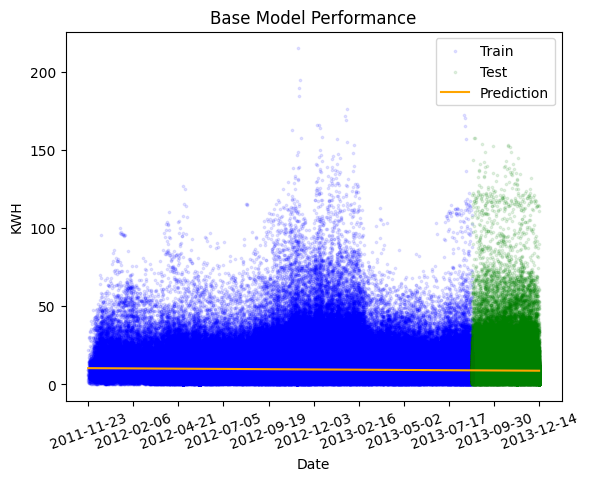

In [5]:
plt.scatter(test_train_splits[-1]["train"]["date_index"], test_train_splits[-1]["train"]["KWH"], color="blue", alpha=0.1, s=3.0, label="Train")
plt.scatter(test_train_splits[-1]["test"]["date_index"], test_train_splits[-1]["test"]["KWH"], color="green", alpha=0.1, s=3.0, label="Test")
xs = [0.0, 1.0]
ys = test_train_splits[-1]["encoder"].inverse_transform([test_train_splits[-1]["model"].predict(np.array(xs)[:, np.newaxis])])[0]
plt.plot(xs, ys, c="orange", label="Prediction")

X_LABEL_COUNT = 10
x_ticks = [(MIN_DATE + ((MAX_DATE - MIN_DATE) * i / (X_LABEL_COUNT + 1))).date() for i in range(X_LABEL_COUNT+1)]

plt.xticks(np.arange(0,1.01,1/(X_LABEL_COUNT)), x_ticks, rotation=20)
plt.xlabel("Date")
plt.ylabel("KWH")
plt.title("Base Model Performance")

plt.legend(loc="upper right")